In [31]:
import pandas as pd
import plotly.express as px

columns = [
        'join_id','dt','chain', 'active_secs_per_day'
        ,'num_l1_txs_inbox','num_l1_txs_output','calldata_bytes_l1_inbox'
        ,'avg_l1_gas_price_on_l1_inbox','avg_l1_gas_price_on_l1_output','avg_l1_gas_price_on_l2'
        ,'l1_gas_used_inbox','l1_gas_used_output','l1_gas_used_combined'
        ,'l1_eth_fees_inbox','l1_eth_fees_output','l1_eth_fees_combined'
        ,'l1_contrib_l2_eth_fees_per_day','l2_contrib_l2_eth_fees_per_day'
        ,'l2_num_txs_per_day','l1_gas_used_on_l2','calldata_bytes_l2_per_day','l2_gas_used','l2_eth_fees_per_day'
        ]

In [32]:
#Unify datasets
dunedf = pd.read_csv('csv_inputs/op_chain_gas_economics_dune_query_2453515.csv')
goldskydf = pd.read_csv('csv_inputs/op_chain_gas_economics_goldsky_zora_pgn.csv')

In [33]:
#Configure
#rename cols
dunedf = dunedf.rename(columns={
                        'name':'chain'
                        })
#Generate Join ID Column
dunedf['join_id'] = dunedf['dt'].astype(str).str[:10].str.cat(dunedf['chain'].astype(str).str.lower())
goldskydf['join_id'] = goldskydf['dt'].astype(str).str[:10].str.cat(goldskydf['chain'].astype(str).str.lower())

# display(dunedf.head(10))
# print(dunedf.columns)
# print('---')
# display(goldskydf.head(10))
# print(goldskydf.columns)

combo_df = dunedf.merge(goldskydf, on='join_id', how='left')

# display(combo_df)

for c in columns:
        try:
                combo_df[c] = combo_df[c+'_x'].combine_first(combo_df[c+'_y']) #pick first non-null
        except:
                combo_df[c] = combo_df[c] #nada

combo_df['dt'] = pd.to_datetime(combo_df['dt'])
combo_df = combo_df[columns]

combo_df['gas_compression_ratio'] = combo_df['l1_gas_used_inbox'] / combo_df['l1_gas_used_on_l2']
combo_df['bytes_compression_ratio'] = combo_df['calldata_bytes_l1_inbox'] / combo_df['calldata_bytes_l2_per_day']

In [34]:
display( combo_df.sample(5) )

combo_df.to_csv('outputs/op_chain_gas_economics_sample.csv')

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l1_eth_fees_combined,l1_contrib_l2_eth_fees_per_day,l2_contrib_l2_eth_fees_per_day,l2_num_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio
61,2023-08-10base,2023-08-10 00:00:00+00:00,Base,86400.0,1502,29,94484468.0,22.254103,20.043758,22.078360,...,34.286328,38.964568,92.163636,694769.0,2.580162e+09,162810437.0,1.077029e+11,131.128204,5.963086e-01,0.580334
158,2023-07-17base,2023-07-17 00:00:00+00:00,Base,86400.0,143,24,3808412.0,20.938717,23.688899,20.185095,...,1.384598,0.776185,1.241446,11105.0,5.621841e+07,14216005.0,3.351119e+09,2.017632,1.134293e+00,0.267896
239,2023-06-22base,2023-06-22 00:00:00+00:00,Base,86400.0,1429,24,2044423.0,16.751815,15.473995,16.842574,...,1.079298,0.000045,0.000093,2.0,3.548000e+03,11232000.0,2.169176e+09,0.000138,1.761649e+04,0.182018
224,2023-06-27base,2023-06-27 00:00:00+00:00,Base,86400.0,1419,24,2035154.0,17.900429,17.513913,17.473365,...,1.148926,0.000024,0.000032,1.0,1.856000e+03,11232420.0,2.169804e+09,0.000056,3.348329e+04,0.181186
163,2023-07-16public goods network,2023-07-16 00:00:00+00:00,Public Goods Network,86400.0,145,24,1862017.0,15.665246,16.134319,0.000000,...,0.547217,0.000000,0.000000,0.0,0.000000e+00,11232000.0,4.320000e+10,0.000000,inf,0.165778


In [43]:
bl_gas_ratio = combo_df['l1_gas_used_inbox'].sum() / combo_df['l1_gas_used_on_l2'].sum()
bl_bytes_ratio = combo_df['calldata_bytes_l1_inbox'].sum() / combo_df['calldata_bytes_l2_per_day'].sum()
print('Blended gas compression ratio: ' + str(round(bl_gas_ratio*100,1)) + '%')
print('Blended bytes compression ratio: ' + str(round(bl_bytes_ratio*100,1)) + '%')

Blended gas compression ratio: 62.0%
Blended bytes compression ratio: 43.3%


In [35]:
# Create the scatter plot
combo_df_plot = combo_df[
                        (~combo_df['gas_compression_ratio'].isna()) 
                         & (combo_df['gas_compression_ratio']<1) 
                         & (combo_df['active_secs_per_day'] == 86400)
                         ]

# combo_df_plot = combo_df[(~combo_df['bytes_compression_ratio'].isna())
#                          & (combo_df['active_secs_per_day'] == 86400)]

display(combo_df_plot)

fig = px.scatter(combo_df_plot,
                 x='l1_gas_used_on_l2',
                 y='l1_gas_used_inbox',
                 size = 'gas_compression_ratio',
                 color='chain',
                 title='L1 Gas Used on each Layer by chain')

# Display the plot
fig.show()

##############

fig_bytes = px.scatter(combo_df_plot,
                 x='calldata_bytes_l2_per_day',
                 y='calldata_bytes_l1_inbox',
                 size = 'bytes_compression_ratio',
                 color='chain',
                 title='Calldata Bytese on each Layer by chain')

fig_bytes.show()

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l1_eth_fees_combined,l1_contrib_l2_eth_fees_per_day,l2_contrib_l2_eth_fees_per_day,l2_num_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio
0,2023-08-25base,2023-08-25 00:00:00+00:00,Base,86400.0,1440,24,88661392.0,22.787053,22.723888,22.758732,...,32.963552,37.666664,72.411145,661591.0,2.419653e+09,155049018.0,1.491678e+11,110.077808,0.596992,0.571828
1,2023-08-25op mainnet,2023-08-25 00:00:00+00:00,OP Mainnet,86400.0,573,24,66223249.0,22.568046,22.448241,22.410028,...,24.164376,25.418278,8.804248,328085.0,1.658241e+09,141443650.0,1.092216e+11,34.222525,0.644454,0.468195
2,2023-08-25zora network,2023-08-25 00:00:00+00:00,Zora Network,86400.0,146,24,8340159.0,21.828754,22.316142,21.301424,...,3.017552,2.735441,3.727446,56677.0,1.885466e+08,22535690.0,5.579137e+10,6.462887,0.721873,0.370087
4,2023-08-24base,2023-08-24 00:00:00+00:00,Base,86400.0,1448,24,100567568.0,19.969681,19.444368,19.980131,...,32.684194,36.878242,25.905074,677920.0,2.698459e+09,181022990.0,1.234228e+11,62.783316,0.605776,0.555551
5,2023-08-24op mainnet,2023-08-24 00:00:00+00:00,OP Mainnet,86400.0,657,24,75993613.0,19.924479,19.271690,19.742130,...,24.473945,26.188730,9.693352,385821.0,1.939386e+09,164898770.0,1.181605e+11,35.882083,0.632323,0.460850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2023-06-11op mainnet,2023-06-11 00:00:00+00:00,OP Mainnet,86400.0,698,24,75076007.0,17.448444,16.546322,17.139167,...,21.190742,23.707469,6.093116,386861.0,2.022271e+09,176495625.0,1.470628e+11,29.800585,0.599574,0.425370
268,2023-06-10op mainnet,2023-06-10 00:00:00+00:00,OP Mainnet,86400.0,761,24,82801904.0,25.358090,22.331480,24.693872,...,33.950999,36.913817,23.830153,428146.0,2.185464e+09,185772721.0,1.885652e+11,60.743970,0.611782,0.445716
269,2023-06-09op mainnet,2023-06-09 00:00:00+00:00,OP Mainnet,86400.0,725,24,78404424.0,21.023144,20.588342,20.835285,...,26.662064,29.647822,3.031154,421558.0,2.080354e+09,177070170.0,1.326059e+11,32.678976,0.608638,0.442787
270,2023-06-08op mainnet,2023-06-08 00:00:00+00:00,OP Mainnet,86400.0,680,24,72779082.0,24.181462,23.095756,23.896230,...,28.473471,31.640666,5.186460,394661.0,1.935798e+09,166145549.0,1.154944e+11,36.827127,0.607243,0.438044


In [36]:
df = combo_df.copy()

In [37]:
# GPT Built model
from sklearn.model_selection import train_test_split

# Selecting the features and target variable
features = ['l1_gas_used_on_l2', 'calldata_bytes_l2_per_day', 'l2_num_txs_per_day']
target = 'l1_gas_used_inbox'

# Drop rows with missing values for now
df_cleaned = df.dropna(subset=features + [target])

# Splitting the data into training and testing sets (80% train, 20% test)
X = df_cleaned[features]
y = df_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((211, 3), (53, 3))

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, mse, r2

(21667300.97534015, 1885579767800016.2, 0.9961688245226951)

In [39]:
# Retrieve the coefficients and intercept of the model
coefficients = model.coef_
intercept = model.intercept_

coefficients, intercept


(array([   0.65433478,   -0.49291367, -159.85795107]), 40193003.723002076)

```
r^2 = .9962

l1_gas_used_inbox =
          0.6543×l1_gas_used_on_l2
        − 0.4929×calldata_bytes_l2_per_day
        − 159.8580×l2_num_txs_per_day
        + 40,193,003.72
```
        

In [40]:
# test other features

# Identify columns that do not include 'l1' and 'compression_ratio', except for the one already identified
potential_features = [col for col in df.columns if 'l1' not in col and 'compression_ratio' not in col]
potential_features.append('l1_gas_used_on_l2')  # add the already identified feature

# Remove the non-feature columns (like identifiers and target)
non_feature_columns = ['Unnamed: 0', 'join_id', 'dt', 'chain']
potential_features = [col for col in potential_features if col not in non_feature_columns]

potential_features



['active_secs_per_day',
 'l2_contrib_l2_eth_fees_per_day',
 'l2_num_txs_per_day',
 'calldata_bytes_l2_per_day',
 'l2_gas_used',
 'l2_eth_fees_per_day',
 'l1_gas_used_on_l2']

In [42]:
# Re-preprocess the data considering all potential features
df_cleaned_all = df.dropna(subset=potential_features + [target])

# Splitting the data again
X_all = df_cleaned_all[potential_features]
y_all = df_cleaned_all[target]

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Updated function to evaluate features using the new datasets
def evaluate_features_updated(features_list):
    X_train_subset = X_train_all[features_list]
    X_test_subset = X_test_all[features_list]

    # Train the model
    model = LinearRegression()
    model.fit(X_train_subset, y_train_all)

    # Predict and evaluate
    y_pred = model.predict(X_test_subset)
    r2 = r2_score(y_test_all, y_pred)
    return r2

# Re-evaluate models
original_r2_updated = evaluate_features_updated(['l1_gas_used_on_l2', 'calldata_bytes_l2_per_day', 'l2_num_txs_per_day'])
all_features_r2_updated = evaluate_features_updated(potential_features)

# Removing one feature at a time from the full set
drop_one_r2_updated = {}
for feature in potential_features:
    subset = [f for f in potential_features if f != feature]
    r2 = evaluate_features_updated(subset)
    drop_one_r2_updated[feature] = r2

original_r2_updated, all_features_r2_updated, drop_one_r2_updated
print('this shows that our original model was "best"')

this shows that our original model was "best"


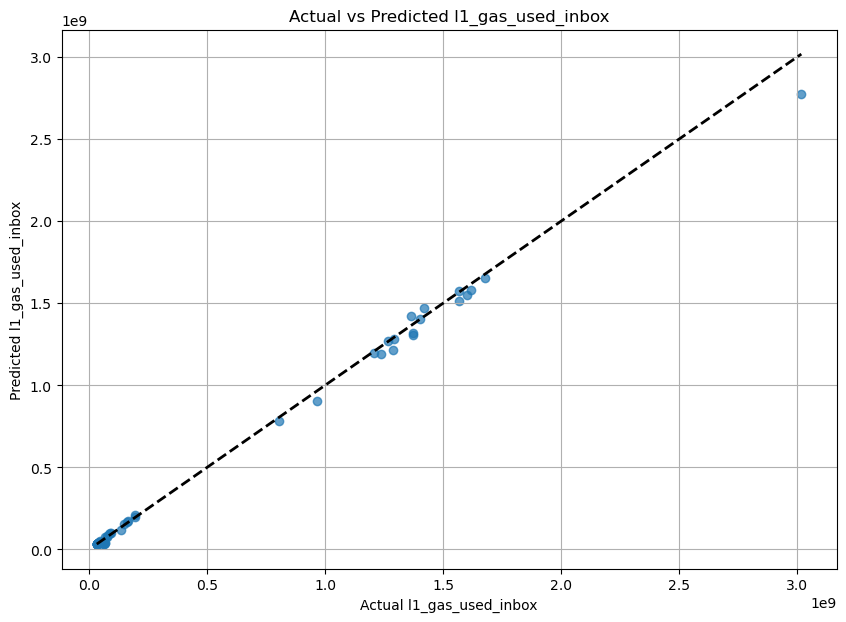

In [46]:
# Train the best model on the original set of features
best_features = ['l1_gas_used_on_l2', 'calldata_bytes_l2_per_day', 'l2_num_txs_per_day']
X_train_best = X_train_all[best_features]
X_test_best = X_test_all[best_features]

best_model = LinearRegression()
best_model.fit(X_train_best, y_train_all)

# Retrieve the coefficients and intercept of the best model
best_coefficients = best_model.coef_
best_intercept = best_model.intercept_

best_coefficients, best_intercept

import matplotlib.pyplot as plt

# Predict with the best model
y_pred_best = best_model.predict(X_test_best)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 7))
plt.scatter(y_test_all, y_pred_best, alpha=0.7)
plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'k--', lw=2)
plt.xlabel('Actual l1_gas_used_inbox')
plt.ylabel('Predicted l1_gas_used_inbox')
plt.title('Actual vs Predicted l1_gas_used_inbox')
plt.grid(True)
plt.show()


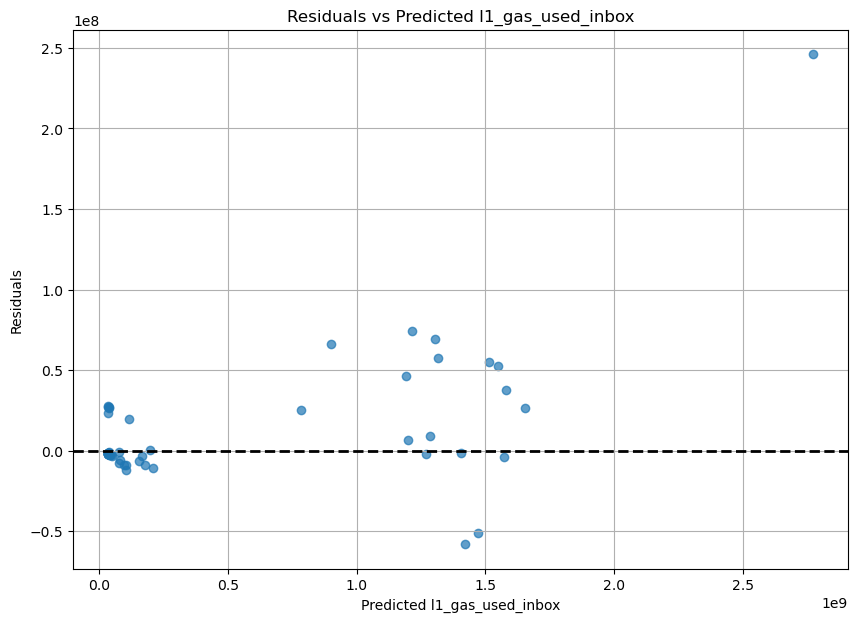

In [47]:
# Test Polynomial Model

# Calculate residuals
residuals = y_test_all - y_pred_best

# Plotting residuals against predicted values
plt.figure(figsize=(10, 7))
plt.scatter(y_pred_best, residuals, alpha=0.7)
plt.axhline(0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted l1_gas_used_inbox')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted l1_gas_used_inbox')
plt.grid(True)
plt.show()


In [48]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_transformer.fit_transform(X_train_best)
X_test_poly = poly_transformer.transform(X_test_best)

# Train the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_all)

# Predict and evaluate
y_pred_poly = poly_model.predict(X_test_poly)
r2_poly = r2_score(y_test_all, y_pred_poly)
mae_poly = mean_absolute_error(y_test_all, y_pred_poly)
mse_poly = mean_squared_error(y_test_all, y_pred_poly)

r2_poly, mae_poly, mse_poly


(0.9974031308496898, 21857768.803784978, 1278094401693540.5)

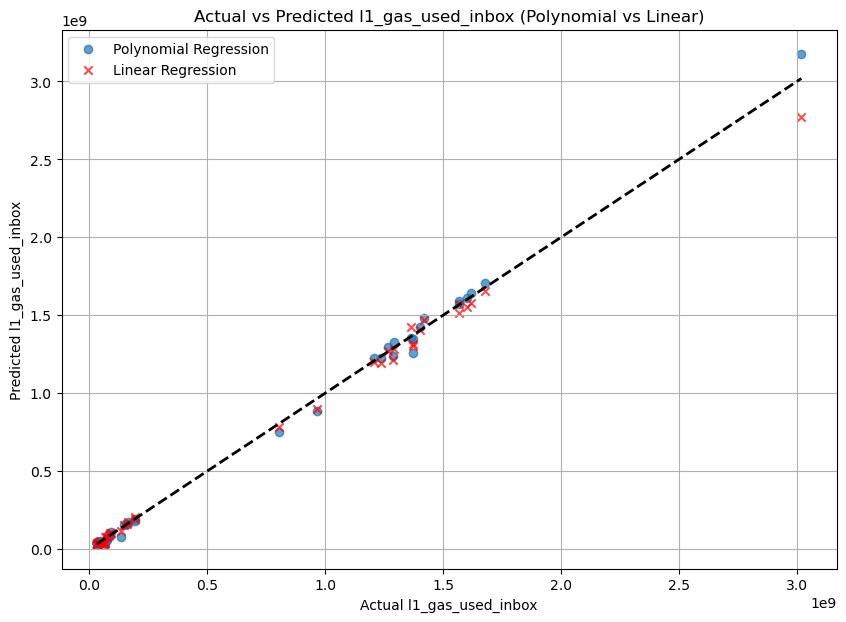

In [49]:
# Plotting actual vs predicted values for the polynomial regression model
plt.figure(figsize=(10, 7))
plt.scatter(y_test_all, y_pred_poly, alpha=0.7, label='Polynomial Regression')
plt.scatter(y_test_all, y_pred_best, alpha=0.7, color='red', marker='x', label='Linear Regression')
plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'k--', lw=2)
plt.xlabel('Actual l1_gas_used_inbox')
plt.ylabel('Predicted l1_gas_used_inbox')
plt.title('Actual vs Predicted l1_gas_used_inbox (Polynomial vs Linear)')
plt.legend()
plt.grid(True)
plt.show()


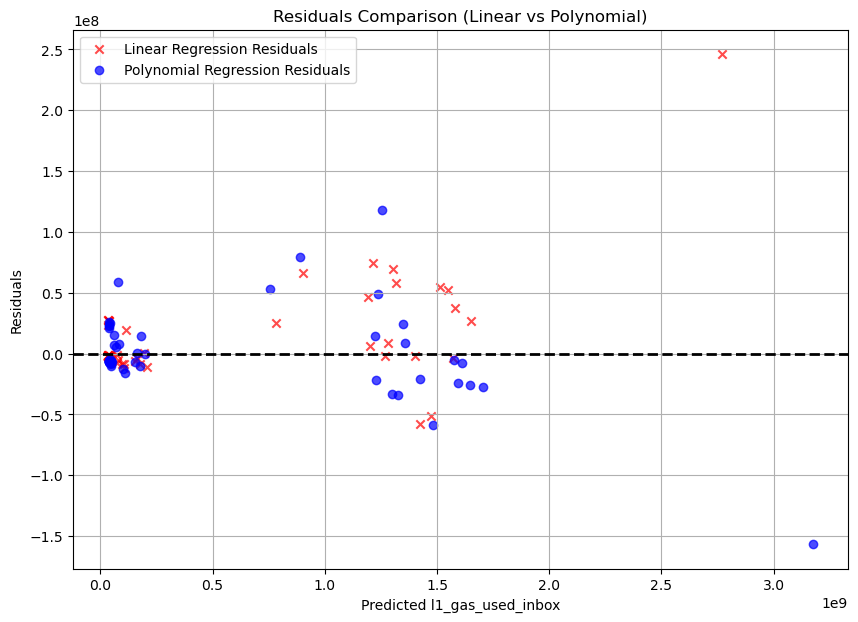

AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names'

In [51]:
# Calculate residuals for the polynomial model
residuals_poly = y_test_all - y_pred_poly

# Plotting residuals comparison
plt.figure(figsize=(10, 7))
plt.scatter(y_pred_best, residuals, alpha=0.7, color='red', marker='x', label='Linear Regression Residuals')
plt.scatter(y_pred_poly, residuals_poly, alpha=0.7, color='blue', label='Polynomial Regression Residuals')
plt.axhline(0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted l1_gas_used_inbox')
plt.ylabel('Residuals')
plt.title('Residuals Comparison (Linear vs Polynomial)')
plt.legend()
plt.grid(True)
plt.show()

# Retrieve the coefficients from the polynomial model
poly_coefficients = poly_model.coef_
poly_intercept = poly_model.intercept_

# Mapping feature names to their polynomial terms
feature_names = poly_transformer.get_feature_names(input_features=best_features)

poly_equation = f"l1_gas_used_inbox = {poly_intercept:.2f}"
for coef, feature in zip(poly_coefficients, feature_names):
    poly_equation += f" + {coef:.2f}*{feature}"

poly_equation


#### Linear Model
$$
\begin{align*}
\text{l1\_gas\_used\_inbox} &= 40,193,003.72 \\
&+ 0.6543 \times \text{l1\_gas\_used\_on\_l2} \\
&- 0.4929 \times \text{calldata\_bytes\_l2\_per\_day} \\
&- 159.8580 \times \text{l2\_num\_txs\_per\_day} \\
R^2 &= 0.9962 \\
\end{align*}


#### Polynomial Model
$$
\begin{align*}
\text{l1\_gas\_used\_inbox} &= -88,399,846.41 \\
&- 1.03 \times \text{l1\_gas\_used\_on\_l2} \\
&+ 13.77 \times \text{calldata\_bytes\_l2\_per\_day} \\
&+ 2824.17 \times \text{l2\_num\_txs\_per\_day} \\
&- 0.00 \times \text{l1\_gas\_used\_on\_l2}^2 \\
&+ 0.00 \times \text{l1\_gas\_used\_on\_l2} \times \text{calldata\_bytes\_l2\_per\_day} \\
&+ 0.00 \times \text{l1\_gas\_used\_on\_l2} \times \text{l2\_num\_txs\_per\_day} \\
&- 0.00 \times \text{calldata\_bytes\_l2\_per\_day}^2 \\
&- 0.00 \times \text{calldata\_bytes\_l2\_per\_day} \times \text{l2\_num\_txs\_per\_day} \\
&- 0.01 \times \text{l2\_num\_txs\_per\_day}^2 \\
R^2 &= 0.9974 \\
\end{align*}


Linear model is much simpler, so let's just use that. It breaks down a bit at larger gas used environments, so we'll refine as we have more days like that.

Note: This only applies to the standard OP Chain config. We have a more detailed projection model for changed configs, but note that the config change model is way more involved and potentially inaccurate